In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

## Exploring The Full Dataset

For the first round of merged data, with all features finally scraped, cleaned, and merged in one place, I cleaned and standardized the budget and domestic grosses columns and began to subset different feature classes as potential influencers of the target variable, the domestic gross.  

I visualized subsets based on MPAA ratings versus genres versus director film counts, in order to determine which features might be most useful for a final model.  I then tried each of these feature subsets paired with the `imdb_rating`, `tomatometer`, or `metascore` ratings in turn, to see if any visually distinct correlations might come through.

In [14]:
movie_features = pd.DataFrame(pd.read_json('movie_features.json', lines=True))

In [15]:
movie_features.shape

(1890, 35)

In [139]:
budget_df = pd.DataFrame(pd.read_json('budget_data.json', lines=True))

In [256]:
budget_df.head()

,title,release_date,budget,dom_gross,ww_gross,title_cc,release_date2
0,Valerian and the City of a Thousand Planets,2017-07-20,180000000,40479370,40479370,valerian_and_the_city_of_a_thousand_planets,"Jul 20, 2017"
1,Bolt,2008-11-21,150000000,114053579,114053579,bolt,"Nov 21, 2008"
2,Monster Trucks,2016-12-29,125000000,33370166,33370166,monster_trucks,"Dec 29, 2016"
3,The Expendables 2,2012-08-15,100000000,85028192,85028192,the_expendables_2,"Aug 15, 2012"
4,Bicentennial Man,1999-12-17,90000000,58220776,58220776,bicentennial_man,"Dec 17, 1999"


In [141]:
budget_df.shape

(5050, 7)

In [145]:
type(budget_df['release_date2'])

pandas.core.series.Series

In [202]:
budget_df[budget_df['release_date2']==None]

,title,release_date,budget,dom_gross,ww_gross,title_cc,release_date2


In [217]:
budget_df.iloc[3670]

title            Star Wars Ep. IV: A New Hope
release_date                     May 25, 1977
budget                            $11,000,000
dom_gross                        $460,998,007
ww_gross                         $775,398,007
title_cc           star_wars_ep_iv_a_new_hope
release_date2                    May 25, 1977
Name: 3671, dtype: object

In [171]:
budget_df['release_date']= pd.Series(budget_df['release_date2']).str.replace('Unknown', '', regex=True)

In [203]:
budget_df['release_date']= budget_df['release_date'].str.replace('Fall, 2021', '', regex=True)

In [218]:
budget_df['release_date']= budget_df['release_date'].str.replace('None', '', regex=True)

In [204]:
budget_df['release_date']= budget_df['release_date'].str.strip()

In [205]:
budget_df[budget_df['release_date']=='Fall, 2021']

,title,release_date,budget,dom_gross,ww_gross,title_cc,release_date2


In [239]:
budget_df['budget'].head()

0     $180,000,000
1     $150,000,000
2     $125,000,000
3     $100,000,000
4      $90,000,000
Name: budget, dtype: object

In [219]:
budget_df['release_date']= pd.to_datetime(budget_df['release_date'])

In [242]:
budget_df['budget']=budget_df['budget'].str.strip('[$\xa0]')

In [244]:
budget_df['budget']=budget_df['budget'].str.replace(',', '', regex=True)

In [245]:
budget_df['budget']=budget_df['budget'].astype('int64')

In [248]:
budget_df['dom_gross']=budget_df['dom_gross'].str.strip('[$\xa0]')

In [250]:
budget_df['dom_gross']=budget_df['dom_gross'].str.replace(',', '', regex=True)

In [252]:
budget_df['dom_gross']=budget_df['dom_gross'].astype('int64')

In [254]:
budget_df['dom_gross'].sample(25)

2123      3765585
2674     57386418
4210     10284523
3486      5002310
1362     92115211
3986      3573673
1387     48114556
3598     14915773
4548     32462372
4083      5001655
604     153294164
1250     35188640
755     336045770
1158    164606800
4373      1579146
3251     21403519
2609    132092958
878      70278893
1624     12082391
3319      2203641
923      15738632
699       1311213
1459     35228696
3594     17292381
2685     48548426
Name: dom_gross, dtype: int64

In [253]:
budget_df['ww_gross']=budget_df['ww_gross'].astype('int64')

In [249]:
budget_df['ww_gross']=budget_df['ww_gross'].str.strip('[$\xa0]')

In [251]:
budget_df['ww_gross']=budget_df['dom_gross'].str.replace(',', '', regex=True)

In [255]:
budget_df['ww_gross'].sample(25)

4795      9821335
4969      6644000
1225     50824620
1339     10547117
1181    148478011
4242     45729221
1995     63658910
118      90759676
3347            0
1534     55143823
4346     24103594
2194     37053924
1765     63075011
2650    121697323
1940      1308696
2863       305070
1447    116089678
96      608581744
1896     28946615
3937       139034
1219     55703475
3041     71502303
1102     66207920
2843      2949212
4827       354704
Name: ww_gross, dtype: int64

In [257]:
budget_df.to_json('budget_df_cleaned.json', orient='records', lines=True)

In [22]:
pd.reset_option('all')


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



/Users/jess/workspace/anaconda3/lib/python3.8/site-packages/pandas/_config/config.py:622: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


In [17]:
movie_features.info

<bound method DataFrame.info of <class 'pandas.core.frame.DataFrame'>
RangeIndex: 1890 entries, 0 to 1889
Columns: 35 entries, title_x to genre_01_Sci-Fi
dtypes: float64(8), int64(22), object(5)>

In [115]:
movie_features['age'] = (movie_features['year'] - min(movie_features['year']))

In [124]:
movie_features['rev_age'] = (2021-movie_features['year'])

In [116]:
movie_features.corr()

,year,runtime,imdb_rating,votes,metascore,dom_gross,tomatometer,tomato_ct,aud_score,director_count2,...,mpaa_rating_R,genre_01_Adventure,genre_01_Animation,genre_01_Comedy,genre_01_Drama,genre_01_Fantasy,genre_01_Horror,genre_01_Mystery,genre_01_Sci-Fi,age
year,1.000000,0.115986,-0.104845,0.088047,-0.089996,0.116930,-0.009989,0.322230,0.022523,-0.110138,...,-0.087844,-0.127304,0.096471,-0.089151,0.075163,0.028721,-0.172877,0.024076,0.072685,1.000000
runtime,0.115986,1.000000,0.421656,0.490200,0.251877,0.456198,0.171832,0.447318,0.246345,0.246705,...,-0.052362,-0.004879,-0.113997,-0.127170,0.046639,-0.026061,-0.163339,-0.017266,-0.059358,0.115986
imdb_rating,-0.104845,0.421656,1.000000,0.471643,0.719430,0.337676,0.616821,0.385261,0.768707,0.231499,...,0.005738,0.025474,0.204802,-0.032678,0.088628,-0.003103,-0.126228,0.028556,-0.071351,-0.104845
votes,0.088047,0.490200,0.471643,1.000000,0.372467,0.715830,0.267239,0.638358,0.423285,0.332439,...,-0.028625,0.005810,-0.051427,-0.110431,-0.049631,-0.036893,-0.119629,-0.024533,-0.063257,0.088047
metascore,-0.089996,0.251877,0.719430,0.372467,1.000000,0.258929,0.749887,0.329394,0.621750,0.163068,...,0.016332,0.070891,0.085898,0.006552,0.114439,-0.011788,-0.046309,-0.017392,0.004139,-0.089996
dom_gross,0.116930,0.456198,0.337676,0.715830,0.258929,1.000000,0.185163,0.596955,0.277172,0.283000,...,-0.228959,-0.024594,-0.007409,-0.121846,-0.151146,-0.031773,-0.113798,-0.028307,-0.035938,0.116930
tomatometer,-0.009989,0.171832,0.616821,0.267239,0.749887,0.185163,1.000000,0.198463,0.699171,0.138370,...,0.011975,0.032465,0.125459,0.034763,0.095287,-0.000959,-0.084608,0.036787,-0.041825,-0.009989
tomato_ct,0.322230,0.447318,0.385261,0.638358,0.329394,0.596955,0.198463,1.000000,0.290708,0.192622,...,-0.023196,0.007059,0.036125,-0.097166,-0.009283,-0.031411,-0.142449,-0.069903,-0.039882,0.322230
aud_score,0.022523,0.246345,0.768707,0.423285,0.621750,0.277172,0.699171,0.290708,1.000000,0.175718,...,-0.013182,0.017952,0.161055,-0.021035,0.060372,0.043605,-0.165609,0.000567,-0.006515,0.022523
director_count2,-0.110138,0.246705,0.231499,0.332439,0.163068,0.283000,0.138370,0.192622,0.175718,1.000000,...,0.003798,0.036053,-0.073580,-0.064441,-0.066044,-0.038659,-0.049108,0.029312,-0.074912,-0.110138


In [76]:
movie_features['dom_gross'] = movie_features['dom_gross'].fillna(np.nan).str.strip('$')

In [80]:
movie_features['dom_gross'] = movie_features['dom_gross'].str.replace(',', '')

In [83]:
movie_features['dom_gross']= movie_features['dom_gross'].astype('float')

In [84]:
movie_features['dom_gross'].value_counts()

553171.0       2
135265915.0    1
56491.0        1
600896.0       1
111761982.0    1
11578059.0     1
30234022.0     1
515202542.0    1
9697739.0      1
40283321.0     1
2959.0         1
20534907.0     1
244397.0       1
370698.0       1
97111.0        1
24946533.0     1
55750480.0     1
102744.0       1
257706.0       1
52210049.0     1
60074103.0     1
46378.0        1
66757013.0     1
10037390.0     1
31378.0        1
34400301.0     1
28811.0        1
398663.0       1
214180.0       1
38934842.0     1
5805201.0      1
10942306.0     1
46704056.0     1
6739141.0      1
38577772.0     1
198351526.0    1
844447.0       1
3622.0         1
14307963.0     1
128814019.0    1
5216102.0      1
417719760.0    1
127839.0       1
20056.0        1
6448.0         1
623.0          1
16625807.0     1
10969.0        1
33245.0        1
76113124.0     1
37667746.0     1
48546770.0     1
55100437.0     1
46408.0        1
502153.0       1
1323012.0      1
5344577.0      1
65845974.0     1
38187431.0    

(array([1.03e+03, 9.50e+01, 3.90e+01, 2.50e+01, 1.60e+01, 3.00e+00,
        4.00e+00, 2.00e+00, 1.00e+00, 2.00e+00]),
 array([7.20000000e+01, 9.36662873e+07, 1.87332503e+08, 2.80998718e+08,
        3.74664933e+08, 4.68331148e+08, 5.61997364e+08, 6.55663579e+08,
        7.49329794e+08, 8.42996010e+08, 9.36662225e+08]),
 <BarContainer object of 10 artists>)

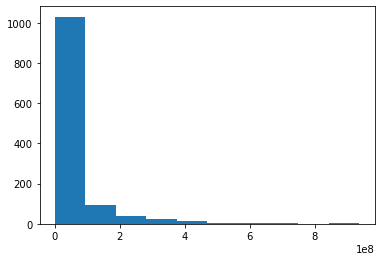

In [85]:
plt.hist(movie_features['dom_gross'])

In [65]:
pd.set_option('display.max_rows', None)

In [70]:
movie_features['dom_gross'].value_counts()

553,171        2
151,493        1
36,594         1
118,919        1
154,696,080    1
5,777,099      1
1,449,232      1
32,868,943     1
18,853         1
20,169         1
8,445          1
67,172,594     1
9,252,038      1
1,738,611      1
64,038,616     1
13,804         1
4,627,375      1
4,973          1
159,731        1
17,291,078     1
277,922        1
390,532,085    1
33,245         1
201,578,182    1
380,270,577    1
1,919,653      1
97,822,171     1
846,704        1
407,728        1
58,032,443     1
20,919,166     1
208,545,589    1
39,127         1
16,928,670     1
81,900,459     1
4,176          1
148,415,853    1
551,281        1
70,308,099     1
1,501          1
250,690,539    1
89,760,956     1
1,079,949      1
417,719,760    1
21,226,204     1
56,110,897     1
40,796         1
25,514,517     1
85,744,662     1
19,075,720     1
958,961        1
71,583,916     1
12,303,080     1
1,236,166      1
202,359,711    1
113,804,681    1
61,363,304     1
38,538,188     1
306,169,268   

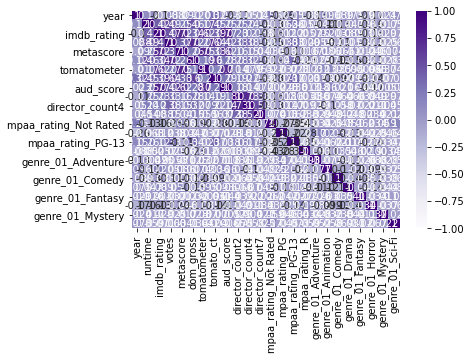

In [86]:
sns.heatmap(movie_features.corr(), cmap='Purples', annot=True, vmin=-1, vmax=1);

In [53]:
movie_features = movie_features.drop(columns=['genre_01_Musical', 'genre_01_Biography', 'genre_01_Documentary','genre_01_Romance', 'genre_01_Family', 'genre_01_Music', 'genre_01_Crime'])

In [88]:
movie_features.columns

Index(['title_x', 'year', 'runtime', 'mpaa_rating', 'imdb_rating',
       'director_name', 'votes', 'metascore', 'dom_gross', 'tomatometer',
       'tomato_ct', 'aud_score', 'aud_score_ct', 'director_count2',
       'director_count4', 'director_count7', 'mpaa_rating_Not Rated',
       'mpaa_rating_PG', 'mpaa_rating_PG-13', 'mpaa_rating_R',
       'genre_01_Adventure', 'genre_01_Animation', 'genre_01_Comedy',
       'genre_01_Drama', 'genre_01_Fantasy', 'genre_01_Horror',
       'genre_01_Mystery', 'genre_01_Sci-Fi'],
      dtype='object')

In [89]:
movie_features['runtime'].value_counts()

90.0     70
95.0     70
88.0     61
91.0     61
93.0     57
98.0     56
92.0     49
99.0     49
100.0    48
89.0     48
94.0     48
85.0     47
87.0     46
96.0     46
97.0     44
104.0    38
84.0     38
101.0    37
103.0    35
109.0    35
108.0    34
107.0    32
86.0     32
106.0    30
102.0    29
110.0    25
105.0    25
119.0    22
113.0    22
112.0    22
111.0    22
81.0     21
82.0     21
83.0     20
120.0    19
80.0     18
115.0    18
118.0    18
117.0    18
124.0    16
116.0    15
114.0    14
132.0    11
126.0    11
129.0    11
123.0    10
136.0    10
127.0    10
121.0    10
77.0     10
78.0      9
125.0     9
131.0     8
130.0     8
79.0      8
75.0      7
134.0     6
122.0     6
141.0     6
135.0     6
137.0     5
143.0     5
138.0     5
154.0     4
76.0      4
72.0      4
145.0     4
139.0     4
73.0      4
140.0     4
162.0     4
128.0     4
146.0     4
142.0     3
149.0     3
71.0      3
148.0     3
74.0      3
70.0      3
152.0     3
144.0     3
69.0      2
62.0      2
50.0

In [55]:
movie_features.shape

(1890, 28)

(array([  5.,  24., 284., 773., 367., 172.,  82.,  26.,  11.,   6.]),
 array([ 45. ,  59.3,  73.6,  87.9, 102.2, 116.5, 130.8, 145.1, 159.4,
        173.7, 188. ]),
 <BarContainer object of 10 artists>)

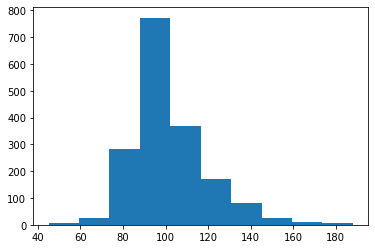

In [90]:
plt.hist(movie_features['runtime'])

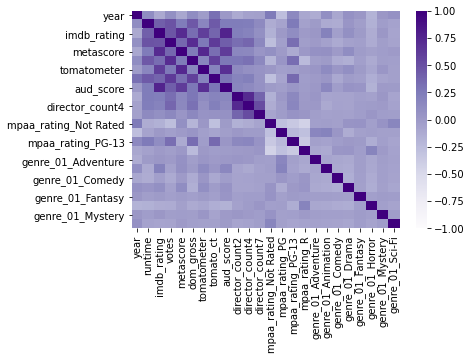

In [87]:
sns.heatmap(movie_features.corr(), cmap='Purples', annot=False, vmin=-1, vmax=1);

In [91]:
gross_genre_features = movie_features[['title_x', 'year', 'dom_gross','genre_01_Adventure', 'genre_01_Animation', 'genre_01_Comedy',
       'genre_01_Drama', 'genre_01_Fantasy', 'genre_01_Horror',
       'genre_01_Mystery', 'genre_01_Sci-Fi']]

In [92]:
gross_rating_features = movie_features[['title_x', 'year', 'runtime',  'dom_gross', 'mpaa_rating_Not Rated',
       'mpaa_rating_PG', 'mpaa_rating_PG-13', 'mpaa_rating_R']]

In [93]:
gross_director_features = movie_features[['title_x', 'year', 'runtime', 'dom_gross', 'director_count2',
       'director_count4', 'director_count7']]

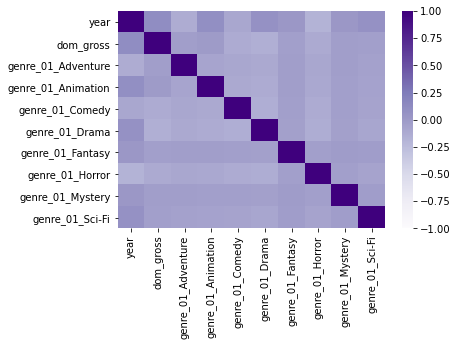

In [94]:
sns.heatmap(gross_genre_features.corr(), cmap='Purples', annot=False, vmin=-1, vmax=1);

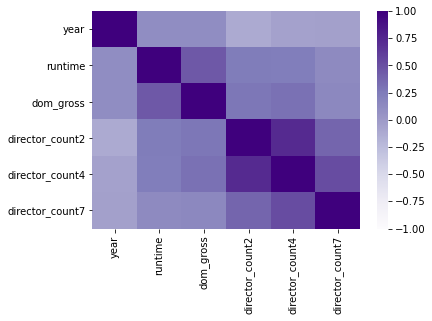

In [95]:
sns.heatmap(gross_director_features.corr(), cmap='Purples', annot=False, vmin=-1, vmax=1);

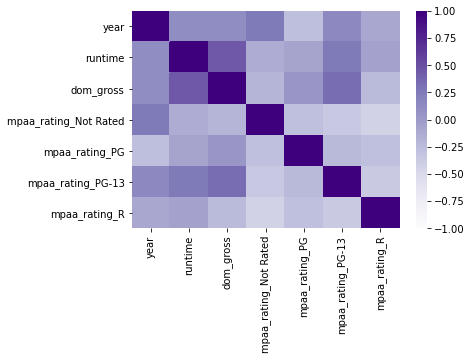

In [96]:
sns.heatmap(gross_rating_features.corr(), cmap='Purples', annot=False, vmin=-1, vmax=1);

In [97]:
metascore_genre_features = movie_features[['title_x', 'year', 'metascore','genre_01_Adventure', 'genre_01_Animation', 'genre_01_Comedy',
       'genre_01_Drama', 'genre_01_Fantasy', 'genre_01_Horror',
       'genre_01_Mystery', 'genre_01_Sci-Fi']]

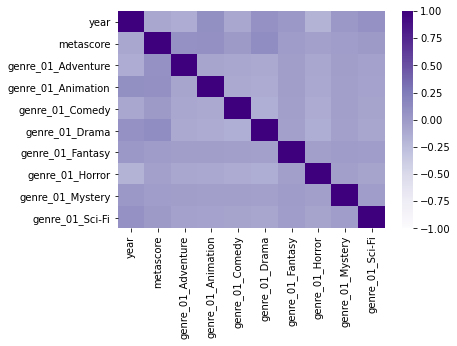

In [98]:
sns.heatmap(metascore_genre_features.corr(), cmap='Purples', annot=False, vmin=-1, vmax=1);

In [99]:
imdb_rate_genre_features = movie_features[['title_x', 'year', 'imdb_rating','genre_01_Adventure', 'genre_01_Animation', 'genre_01_Comedy',
       'genre_01_Drama', 'genre_01_Fantasy', 'genre_01_Horror',
       'genre_01_Mystery', 'genre_01_Sci-Fi']]

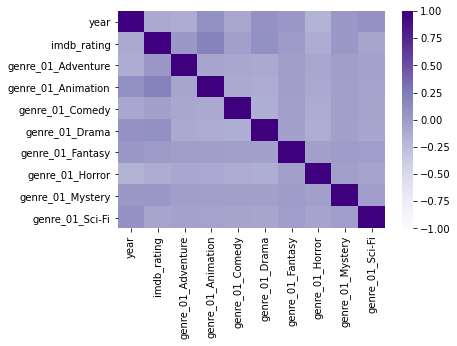

In [100]:
sns.heatmap(imdb_rate_genre_features.corr(), cmap='Purples', annot=False, vmin=-1, vmax=1);

In [101]:
tomatometer_genre_features = movie_features[['title_x', 'year', 'tomatometer','genre_01_Adventure', 'genre_01_Animation', 'genre_01_Comedy',
       'genre_01_Drama', 'genre_01_Fantasy', 'genre_01_Horror',
       'genre_01_Mystery', 'genre_01_Sci-Fi']]

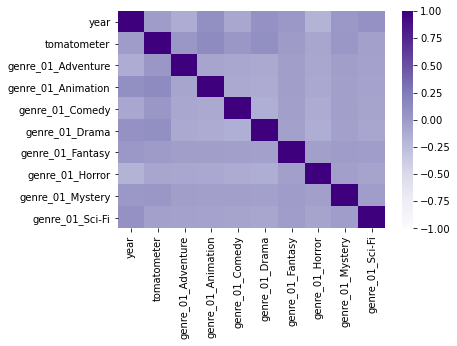

In [103]:
sns.heatmap(tomatometer_genre_features.corr(), cmap='Purples', annot=False, vmin=-1, vmax=1);

In [104]:
metascore_director_features = movie_features[['title_x', 'year', 'runtime', 'dom_gross','metascore', 'director_count2',
       'director_count4', 'director_count7']]

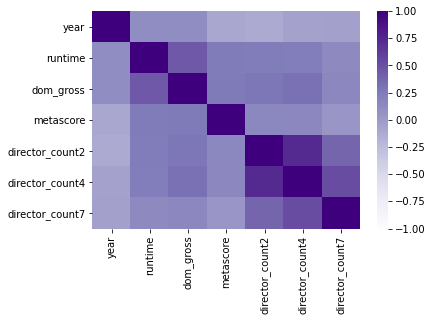

In [105]:
sns.heatmap(metascore_director_features.corr(), cmap='Purples', annot=False, vmin=-1, vmax=1);

In [106]:
imdb_director_features = movie_features[['title_x', 'year', 'runtime', 'dom_gross','imdb_rating', 'director_count2',
       'director_count4', 'director_count7']]

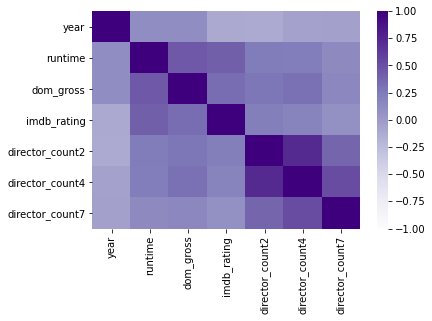

In [107]:
sns.heatmap(imdb_director_features.corr(), cmap='Purples', annot=False, vmin=-1, vmax=1);

In [128]:
gross_scores_features = movie_features[[ 'imdb_rating', 'votes', 'metascore', 'dom_gross', 'tomatometer',
       'tomato_ct', 'aud_score', 'aud_score_ct', 'rev_age']]

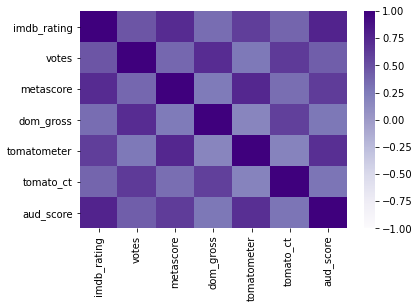

In [112]:
sns.heatmap(gross_scores_features.corr(), cmap='Purples', annot=False, vmin=-1, vmax=1);

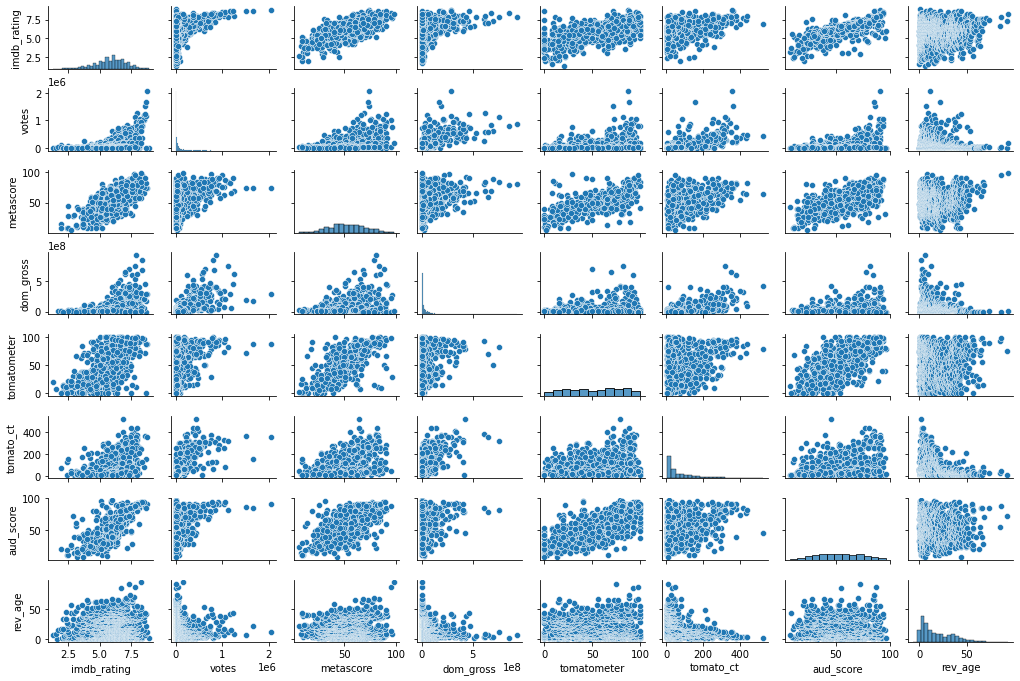

In [129]:
sns.pairplot(gross_scores_features, height = 1.2, aspect=1.5);

Text(0, 0.5, 'Grosses')

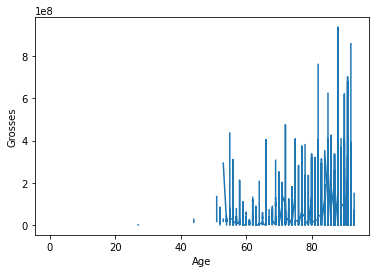

In [118]:
plt.plot(movie_features['age'], movie_features['dom_gross'])
plt.xlabel('Age')
plt.ylabel('Grosses')


In [119]:
movie_features.columns

Index(['title_x', 'year', 'runtime', 'mpaa_rating', 'imdb_rating',
       'director_name', 'votes', 'metascore', 'dom_gross', 'tomatometer',
       'tomato_ct', 'aud_score', 'aud_score_ct', 'director_count2',
       'director_count4', 'director_count7', 'mpaa_rating_Not Rated',
       'mpaa_rating_PG', 'mpaa_rating_PG-13', 'mpaa_rating_R',
       'genre_01_Adventure', 'genre_01_Animation', 'genre_01_Comedy',
       'genre_01_Drama', 'genre_01_Fantasy', 'genre_01_Horror',
       'genre_01_Mystery', 'genre_01_Sci-Fi', 'age'],
      dtype='object')

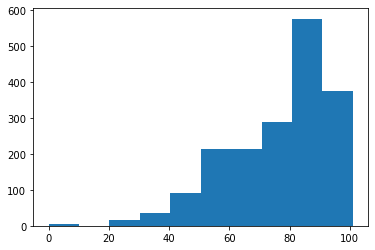

In [122]:
plt.hist(movie_features['age']);

In [123]:
movie_features['age'].describe()

count    1817.000000
mean       76.143093
std        16.257679
min         0.000000
25%        65.000000
50%        82.000000
75%        90.000000
max       101.000000
Name: age, dtype: float64

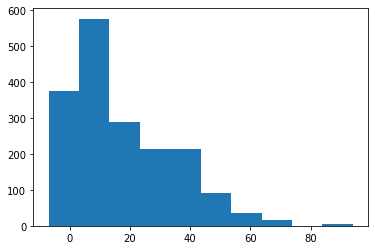

In [125]:
plt.hist(movie_features['rev_age']);

In [126]:
movie_features['rev_age'].describe()

count    1817.000000
mean       17.856907
std        16.257679
min        -7.000000
25%         4.000000
50%        12.000000
75%        29.000000
max        94.000000
Name: rev_age, dtype: float64

Text(0, 0.5, 'Grosses')

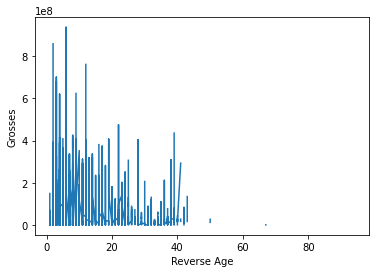

In [127]:
plt.plot(movie_features['rev_age'], movie_features['dom_gross'])
plt.xlabel('Reverse Age')
plt.ylabel('Grosses')


Text(0, 0.5, 'Grosses')

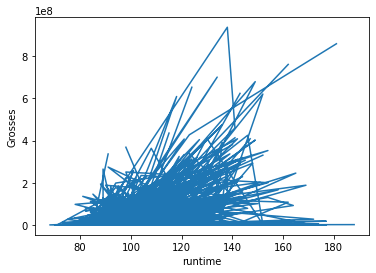

In [135]:
plt.plot(movie_features['runtime'], movie_features['dom_gross'])
plt.xlabel('runtime')
plt.ylabel('Grosses')

In [131]:
movie_features['runtime'].describe()

count    1750.000000
mean      101.373714
std        17.587673
min        45.000000
25%        90.000000
50%        98.000000
75%       109.000000
max       188.000000
Name: runtime, dtype: float64

In [133]:
print(movie_features['runtime'].dropna())

26      101.0
36      100.0
47       60.0
48      114.0
54      136.0
55       87.0
68       99.0
69       89.0
70       91.0
71      150.0
72      119.0
73      107.0
74      109.0
75       93.0
76      132.0
77      108.0
78       91.0
79       78.0
80      104.0
81       83.0
82       94.0
83      141.0
84       88.0
85       92.0
86      101.0
87      105.0
88      110.0
90      105.0
91       70.0
92       79.0
93       99.0
94      114.0
95       92.0
96       94.0
97       95.0
98       94.0
99      103.0
100     124.0
102     118.0
103      87.0
104     113.0
105      84.0
106      91.0
107     110.0
108      83.0
109     131.0
110      90.0
111      78.0
112      91.0
113      77.0
114      91.0
115     165.0
116     119.0
117      88.0
118     100.0
119      88.0
120      91.0
121      78.0
122      93.0
123      84.0
124      95.0
125      95.0
126      52.0
127      85.0
129      70.0
130     134.0
131     109.0
132      84.0
133      87.0
134     104.0
135      76.0
136   

In [136]:
scores_only = movie_features[pd.notna(movie_features['metascore']) & pd.notna(movie_features['tomatometer']) & pd.notna(movie_features['imdb_rating'])]

In [137]:
scores_only.shape

(632, 30)

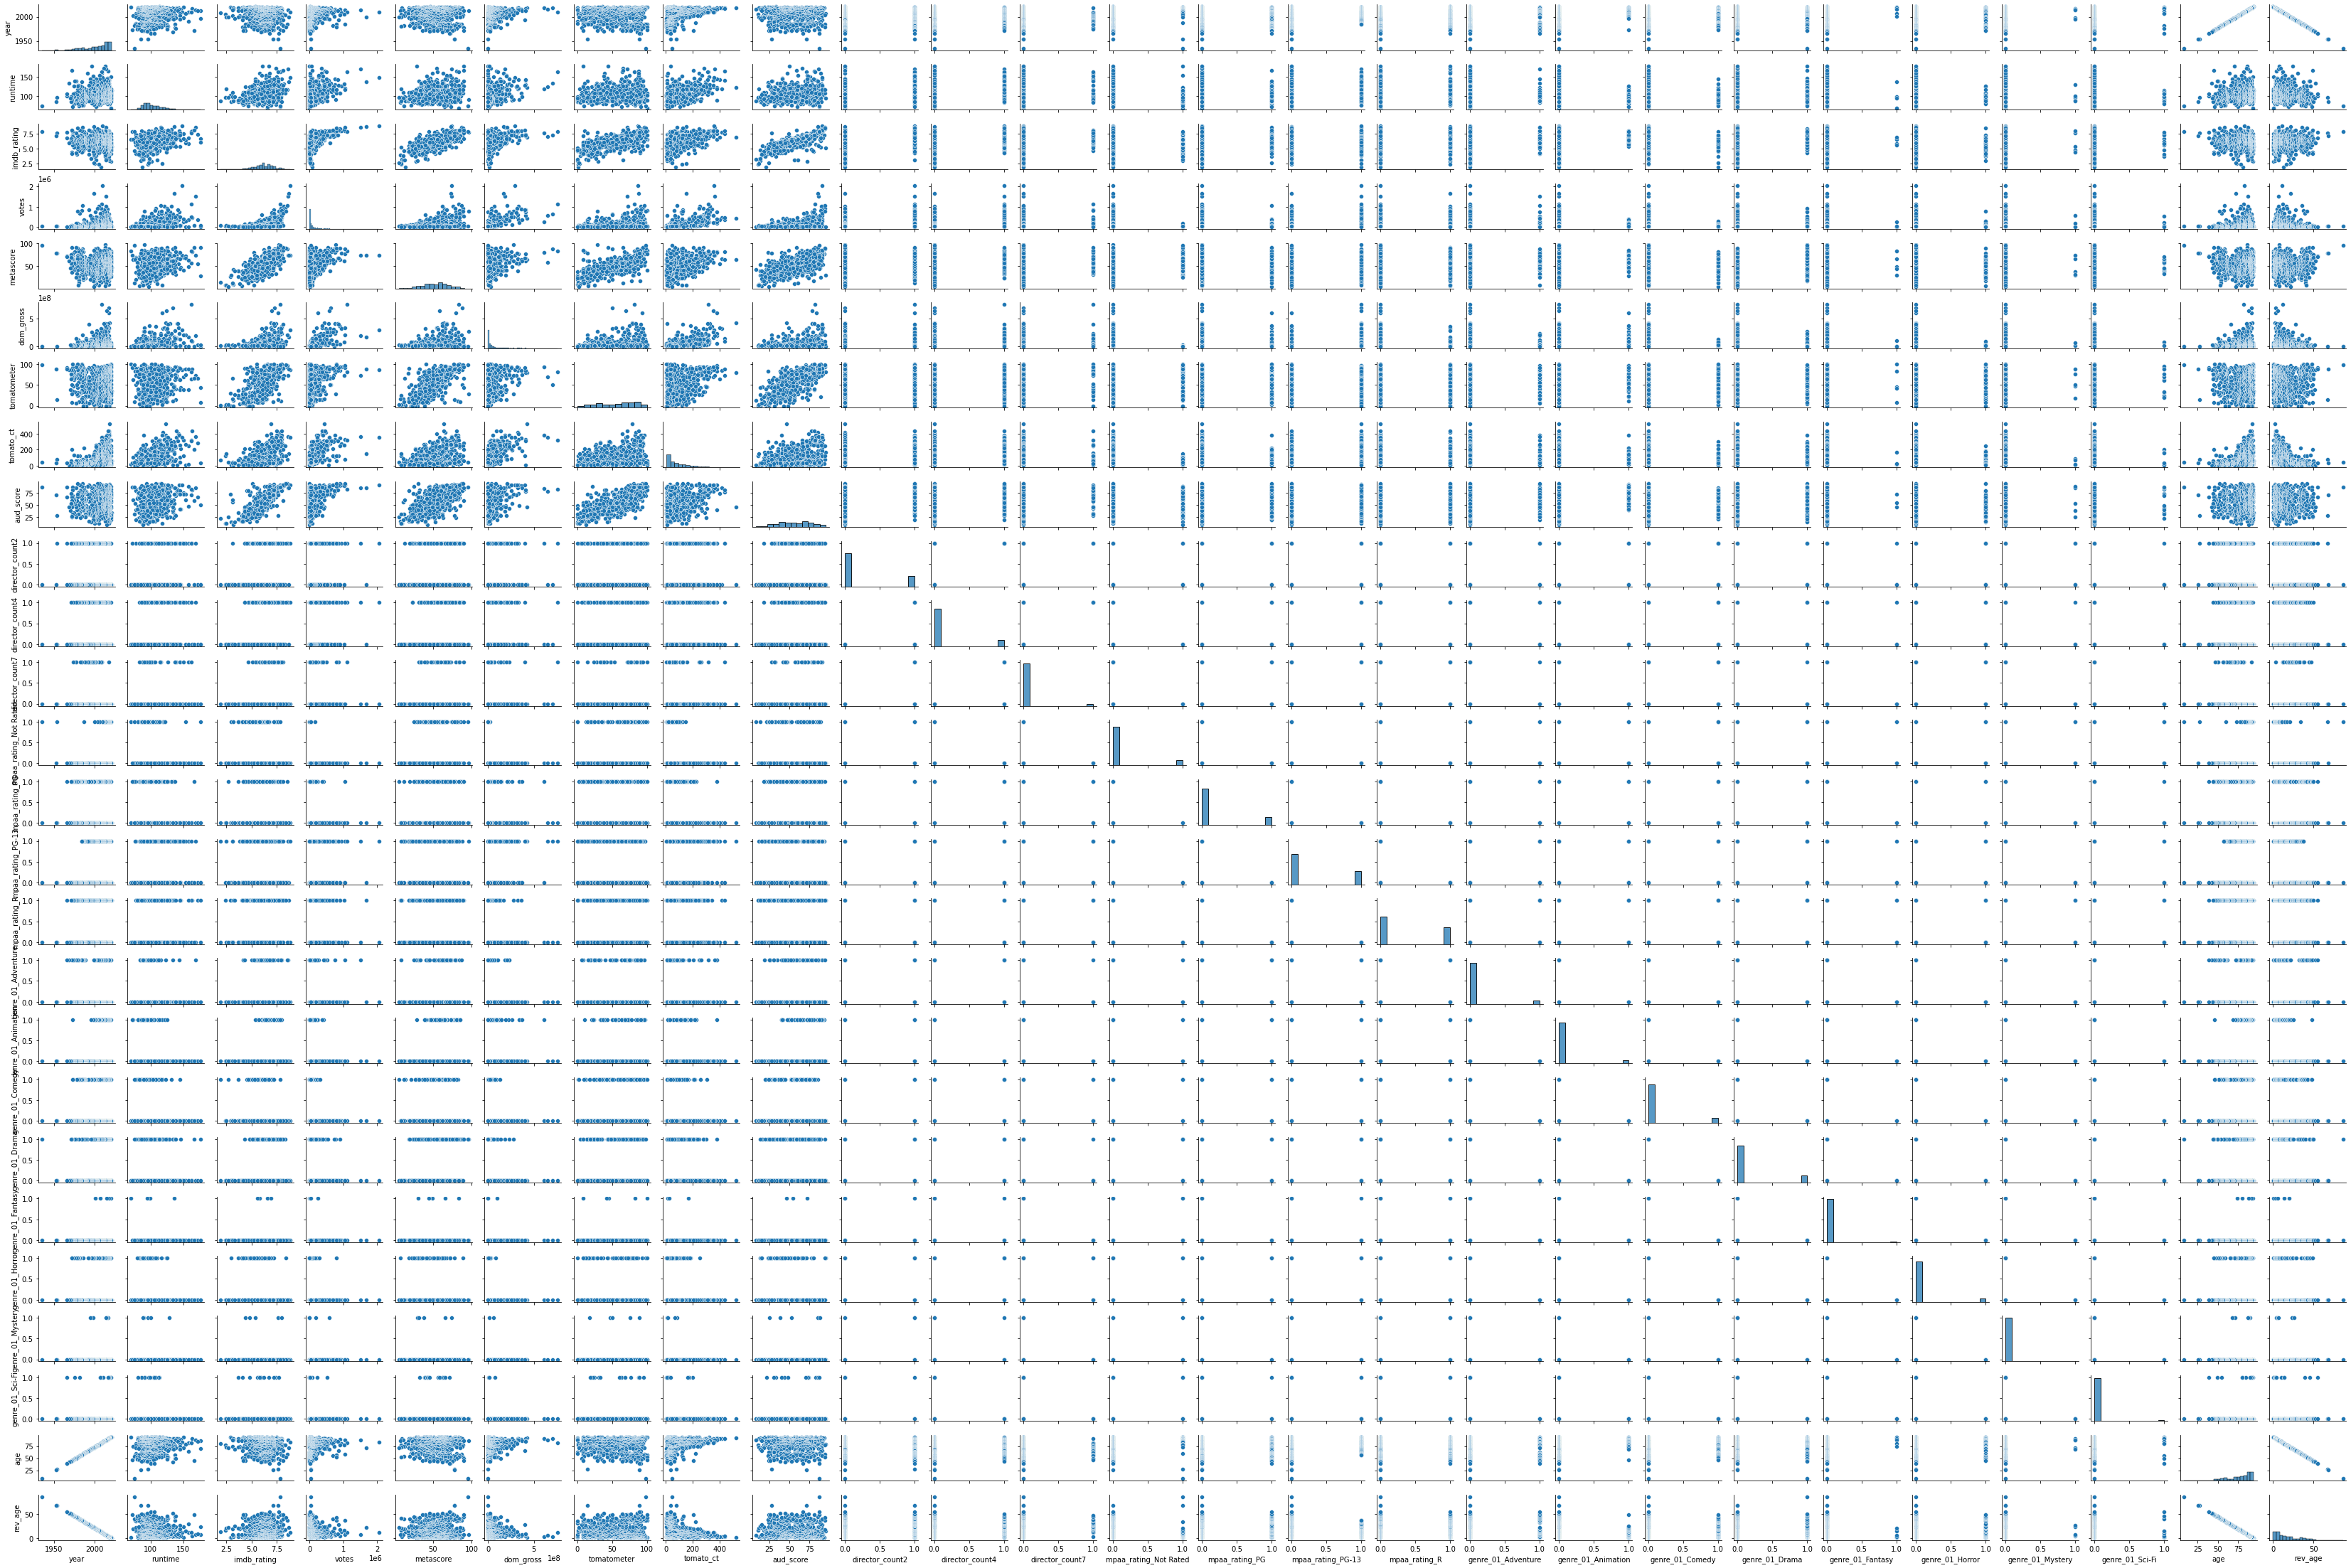

In [138]:
sns.pairplot(scores_only, height = 1.2, aspect=1.5);